In [14]:
import sys
sys.path.append("../src")

from models.s4d import S4DModel, S4DConfig, S4DModelForHourlySeries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_csv("../data/merged_data.csv", parse_dates=["datetime"])
df = df.sort_values("datetime")

df["hour"] = df["datetime"].dt.hour
df["is_daytime"] = ((df["hour"] >= 7) & (df["hour"] < 19)).astype(int)

df = df.drop(columns=["hour"])

df["sin_hour"] = np.sin(2 * np.pi * df["datetime"].dt.hour / 24)
df["cos_hour"] = np.cos(2 * np.pi * df["datetime"].dt.hour / 24)
df["price_lag_1h"] = df["price_EUR_MWh"].shift(1)

df = df.dropna()

# features = [
#     "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation",
#     "quantity_biomass", "quantity_fossil_gas", "quantity_fossil_hard_coal",
#     "quantity_hydro_run_of_river", "quantity_nuclear", "quantity_solar",
#     "quantity_waste", "quantity_wind_offshore", "quantity_wind_onshore",
#     "quantity_other", "quantity_MW"
# ]
# target = "price_EUR_MWh"

features = [
    "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation", "quantity_solar",
    "quantity_other", "price_lag_1h", "is_daytime", "sin_hour", "cos_hour", "quantity_MW"
]
target = "price_EUR_MWh"

# Splitting indices before scaling
val_days = 30
val_size = val_days * 24

train_df = df.iloc[:-val_size]
val_df = df.iloc[-val_size:]

# Fit scalers ONLY on training data
scaler_x = StandardScaler()
scaler_y = StandardScaler()

scaler_x.fit(train_df[features])
scaler_y.fit(train_df[[target]])

# Transform entire dataset safely
X = scaler_x.transform(df[features])
y = scaler_y.transform(df[[target]])

# scaler_x = StandardScaler()
# scaler_y = StandardScaler()

# # X = scaler_x.fit_transform(df[features])
# # y = scaler_y.fit_transform(df[[target]])


In [15]:
print(np.min(X, axis=0), np.max(X, axis=0))

[-2.79735161 -2.02384534 -2.20963828 -0.52653278 -0.63510169 -1.89342118
 -5.69690921 -1.01032921 -1.41891875 -1.40500107 -3.34100512] [ 3.833015    5.75049098  5.66791665  4.50611277  4.17603827 10.14836079
  6.8582169   0.98977639  1.40319921  1.43008911  3.18644873]


In [16]:
class TimeSeriesDataset(Dataset):
    """
    Custom Dataset for time series data with fixed sequence length.
    """
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.seq_len],
            self.y[idx+self.seq_len]
        )

In [17]:
class HourAheadWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model   # your S4DModelForHourlySeries

    def forward(self, x, **kwargs):
        seq = self.base(x, mode="convolutional")  # [B, 24]
        return seq[:, -1]

In [18]:
# Splitting the dataset into training and validation sets
# Assuming the data is hourly and we want to validate on the last 30 days
sequence_length = 168 # 24 hours = 1 day
val_days = 30
val_size = val_days * 24

train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]

val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [19]:
# Model Config

config = S4DConfig(    
    state_size   = 64,
    hidden_size  = 32,
    num_layers   = 1,
    dropout      = 0.1,
)

# Model, optimizer, and loss function
n_epochs = 30

model = HourAheadWrapper(S4DModelForHourlySeries(config, in_features=11)).cuda()
optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
criterion = nn.L1Loss().cuda()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)



# Training the model

model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for x, t in train_loader:
        x, t = x.cuda(), t.cuda()
        optimizer.zero_grad()
        preds = model(x, mode="convolutional")
        # print(f"preds shape: {preds.shape}, t shape: {t.shape}, t.squeeze(-1) shape: {t.squeeze(-1).shape}")
        loss = criterion(preds, t.squeeze(-1))
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, t in val_loader:
            x, t = x.cuda(), t.cuda()
            preds = model(x, mode="convolutional")
            loss = criterion(preds, t.squeeze(-1))
            val_loss += loss.item()
    model.train()

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1, Train Loss: 0.4548, Val Loss: 0.2056
Epoch 2, Train Loss: 0.2615, Val Loss: 0.1896
Epoch 3, Train Loss: 0.2354, Val Loss: 0.1806
Epoch 4, Train Loss: 0.2108, Val Loss: 0.1674
Epoch 5, Train Loss: 0.2000, Val Loss: 0.1635
Epoch 6, Train Loss: 0.2018, Val Loss: 0.1636
Epoch 7, Train Loss: 0.2032, Val Loss: 0.1519
Epoch 8, Train Loss: 0.1826, Val Loss: 0.1537
Epoch 9, Train Loss: 0.1705, Val Loss: 0.1536
Epoch 10, Train Loss: 0.1712, Val Loss: 0.1525
Epoch 11, Train Loss: 0.1689, Val Loss: 0.1515
Epoch 12, Train Loss: 0.1658, Val Loss: 0.1485
Epoch 13, Train Loss: 0.1643, Val Loss: 0.1493
Epoch 14, Train Loss: 0.1645, Val Loss: 0.1508
Epoch 15, Train Loss: 0.1621, Val Loss: 0.1553
Epoch 16, Train Loss: 0.1651, Val Loss: 0.1592
Epoch 17, Train Loss: 0.1649, Val Loss: 0.1518
Epoch 18, Train Loss: 0.1572, Val Loss: 0.1426
Epoch 19, Train Loss: 0.1571, Val Loss: 0.1476
Epoch 20, Train Loss: 0.1584, Val Loss: 0.1420
Epoch 21, Train Loss: 0.1527, Val Loss: 0.1440
Epoch 22, Train Loss: 

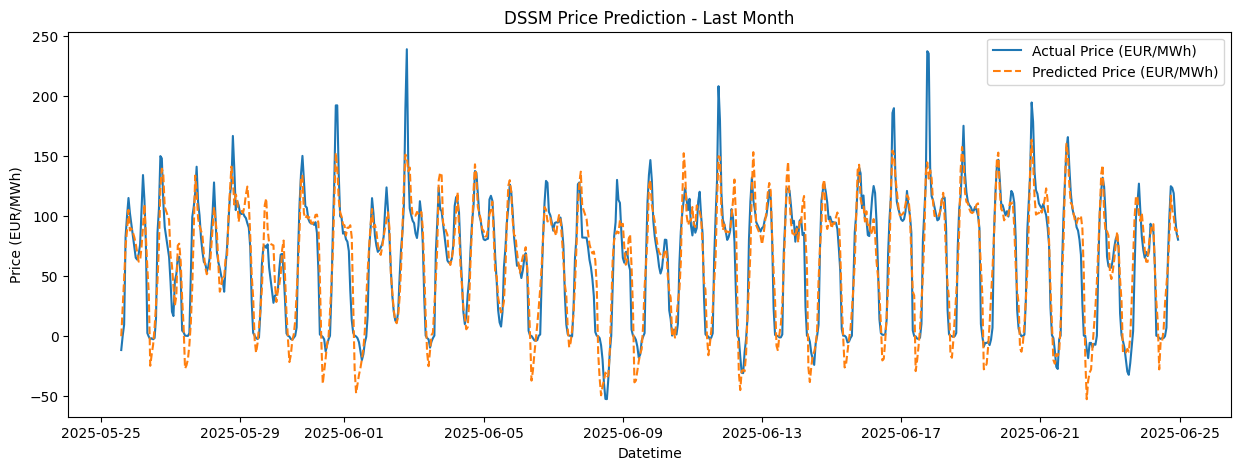

In [26]:
model.eval()
all_preds = []
all_actuals = []
with torch.no_grad():
    for x, t in val_loader:
        x, t = x.cuda(), t.cuda()
        preds = model(x)
        all_preds.append(preds.cpu().numpy())
        all_actuals.append(t.squeeze(-1).cpu().numpy())

preds_flat = np.concatenate(all_preds)
actuals_flat = np.concatenate(all_actuals)

preds_inverse = scaler_y.inverse_transform(preds_flat.reshape(-1, 1)).flatten()
actuals_inverse = scaler_y.inverse_transform(actuals_flat.reshape(-1, 1)).flatten()

# Plotting the results for the last month
val_datetimes = df["datetime"].iloc[-val_size:].reset_index(drop=True)

plt.figure(figsize=(15, 5))
plt.plot(val_datetimes, actuals_inverse, label="Actual Price (EUR/MWh)")
plt.plot(val_datetimes, preds_inverse, label="Predicted Price (EUR/MWh)", linestyle="--")
plt.title("DSSM Price Prediction - Last Month")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()

In [27]:
block_size = 6
total_blocks = 28

# Store results per block
block_metrics = []

for i in range(total_blocks):
    start = i * block_size
    end = (i + 1) * block_size

    block_actuals = actuals_inverse[start:end]
    block_preds = preds_inverse[start:end]

    mse = mean_squared_error(block_actuals, block_preds)
    mae = mean_absolute_error(block_actuals, block_preds)

    denom = (np.abs(block_actuals) + np.abs(block_preds)) / 2
    non_zero_mask = denom != 0
    smape = np.mean(np.abs(block_actuals - block_preds)[non_zero_mask] / denom[non_zero_mask]) * 100

    block_metrics.append({
        "Block": i + 1,
        "Start Hour": start,
        "End Hour": end,
        "MSE": mse,
        "MAE": mae,
        "SMAPE": smape
    })

block_df = pd.DataFrame(block_metrics)

print("\nPer Block Metrics:")
print(block_df.round(2))

# Group into Horizon Tiers
tiers = {
    "Short-term (0-24h)": block_df.iloc[0:4],
    "Medium-term (24-72h)": block_df.iloc[4:12],
    "Long-term (72-168h)": block_df.iloc[12:28]
}

print("\nAggregated Metrics by Horizon Tier:")
for tier_name, tier_df in tiers.items():
    mse_mean = tier_df["MSE"].mean()
    mae_mean = tier_df["MAE"].mean()
    smape_mean = tier_df["SMAPE"].median()
    print(f"\n{tier_name}")
    print(f"MSE: {mse_mean:.2f}")
    print(f"MAE: {mae_mean:.2f}")
    print(f"SMAPE: {smape_mean:.2f}%")


Per Block Metrics:
    Block  Start Hour  End Hour      MSE    MAE       SMAPE
0       1           0         6   411.48  17.23   92.120003
1       2           6        12    76.21   7.70    9.600000
2       3          12        18   512.71  17.27   18.850000
3       4          18        24   840.76  23.28  163.429993
4       5          24        30   665.80  23.37   32.240002
5       6          30        36   710.21  25.65   56.209999
6       7          36        42   240.39  13.91   56.900002
7       8          42        48  1119.12  29.70  167.800003
8       9          48        54   214.76  13.71   12.600000
9      10          54        60    59.74   6.52   10.070000
10     11          60        66   181.25  11.72   12.930000
11     12          66        72   121.35   9.88   20.139999
12     13          72        78   439.19  17.01   13.150000
13     14          78        84    44.19   4.59    4.440000
14     15          84        90   537.31  22.12   51.520000
15     16          9

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actuals_inverse, preds_inverse)
mae = mean_absolute_error(actuals_inverse, preds_inverse)

denom = (np.abs(actuals_inverse) + np.abs(preds_inverse)) / 2
non_zero_mask = denom != 0
smape = np.mean(np.abs(actuals_inverse - preds_inverse)[non_zero_mask] / denom[non_zero_mask]) * 100

print(f"Validation Set Metrics:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")


Validation Set Metrics:
MSE: 407.70
MAE: 14.83


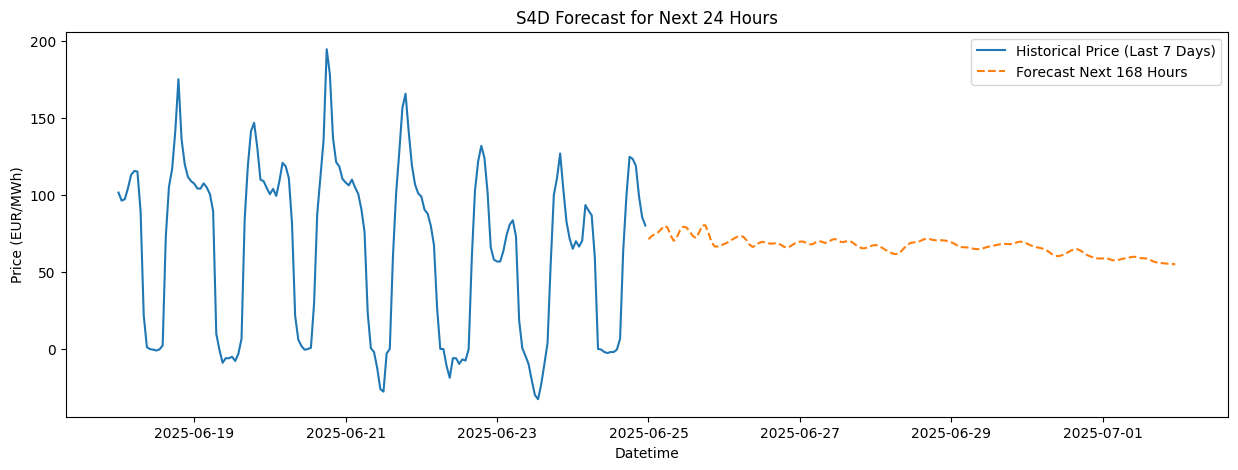

In [29]:
# Forecasting for the next 168 hours
sequence_length = 168

latest_features = df[features].iloc[-sequence_length:]
latest_scaled = scaler_x.transform(latest_features)

input_seq = torch.tensor(latest_scaled, dtype=torch.float32).unsqueeze(0).cuda() # Converting to tensor

model.eval()
forecast = []
current_seq = input_seq.clone()

with torch.no_grad():
    for _ in range(sequence_length):
        pred = model(current_seq, mode = "recurrent").item()
        forecast.append(pred)

        # Shift sequence left, drop first time step
        shifted_seq = current_seq[:, 1:, :].cpu().numpy().squeeze(0)
        next_features = latest_scaled[-1]  # Using last known features as placeholder

        # Append to shifted sequence
        new_seq = np.vstack([shifted_seq, next_features])

        current_seq = torch.tensor(new_seq, dtype=torch.float32).unsqueeze(0).cuda()

# Inverse transform the forecasted values
forecast_inverse = scaler_y.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

# Generate forecast datetimes
last_datetime = df["datetime"].iloc[-1]
forecast_datetimes = pd.date_range(start=last_datetime + pd.Timedelta(hours=1), periods=168, freq="h")

# Plotting the forecast for the next 168 hours
plt.figure(figsize=(15, 5))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price (Last 7 Days)")
plt.plot(forecast_datetimes, forecast_inverse, label="Forecast Next 168 Hours", linestyle="--")
plt.title("S4D Forecast for Next 24 Hours")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()


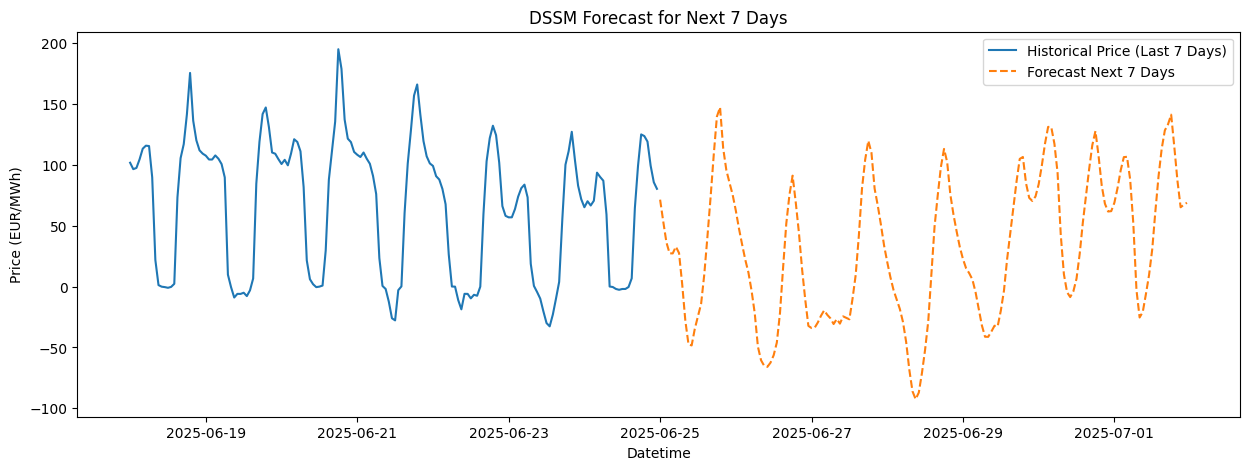

In [30]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

forecast_horizon = 168  # 7 days
sequence_length = 168

# Load weather forecast
weather_df = pd.read_csv("../data/weather_forecast.csv", parse_dates=["datetime"])
weather_df = weather_df.sort_values("datetime").reset_index(drop=True)

# Optional: Scale weather columns now if your model expects scaled weather inputs
weather_features = ["temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation"]
scaler_weather = StandardScaler()
scaler_weather.fit(df[weather_features])  # Fit only on weather columns
# Scale weather forecast
weather_df[weather_features] = scaler_weather.transform(weather_df[weather_features])

# Prepare latest known features
latest_features = df[features].iloc[-sequence_length:].copy()
latest_scaled = scaler_x.transform(latest_features)

input_seq = torch.tensor(latest_scaled, dtype=torch.float32).unsqueeze(0).cuda()
current_seq = input_seq.clone()

forecast_scaled = []
forecast_unscaled = []

for i in range(forecast_horizon):
    model.eval()
    with torch.no_grad():
        pred_scaled = model(current_seq).item()  # Model predicts scaled price
        forecast_scaled.append(pred_scaled)

    pred_unscaled = scaler_y.inverse_transform(np.array([[pred_scaled]]))[0, 0]
    forecast_unscaled.append(pred_unscaled)

    shifted_seq = current_seq[:, 1:, :].squeeze(0).cpu().numpy()
    next_feature = shifted_seq[-1].copy()

    # Update lag price feature with scaled prediction (model output already scaled)
    idx_lag = features.index('price_lag_1h')
    next_feature[idx_lag] = pred_scaled

    # Generate new datetime
    new_datetime = df["datetime"].iloc[-1] + pd.Timedelta(hours=i + 1)

    # Update time features
    idx_day = features.index('is_daytime')
    next_feature[idx_day] = 1 if 6 <= new_datetime.hour < 20 else 0

    idx_sin = features.index('sin_hour')
    idx_cos = features.index('cos_hour')
    next_feature[idx_sin] = np.sin(2 * np.pi * new_datetime.hour / 24)
    next_feature[idx_cos] = np.cos(2 * np.pi * new_datetime.hour / 24)

    # Inject weather forecast if available
    weather_row = weather_df.loc[weather_df["datetime"] == new_datetime]
    if not weather_row.empty:
        for w_feat in weather_features:
            if w_feat in features:
                idx_w = features.index(w_feat)
                next_feature[idx_w] = weather_row.iloc[0][w_feat]
    else:
        print(f"No weather forecast for {new_datetime}, keeping last known values.")

    # Build new input sequence
    new_seq = np.vstack([shifted_seq, next_feature])
    current_seq = torch.tensor(new_seq, dtype=torch.float32).unsqueeze(0).cuda()

# Create forecast datetimes
forecast_datetimes = pd.date_range(
    start=df["datetime"].iloc[-1] + pd.Timedelta(hours=1),
    periods=forecast_horizon,
    freq="h"
)

# Plot historical + forecast
plt.figure(figsize=(15, 5))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price (Last 7 Days)")
plt.plot(forecast_datetimes, forecast_unscaled, label="Forecast Next 7 Days", linestyle="--")
plt.title("DSSM Forecast for Next 7 Days")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()


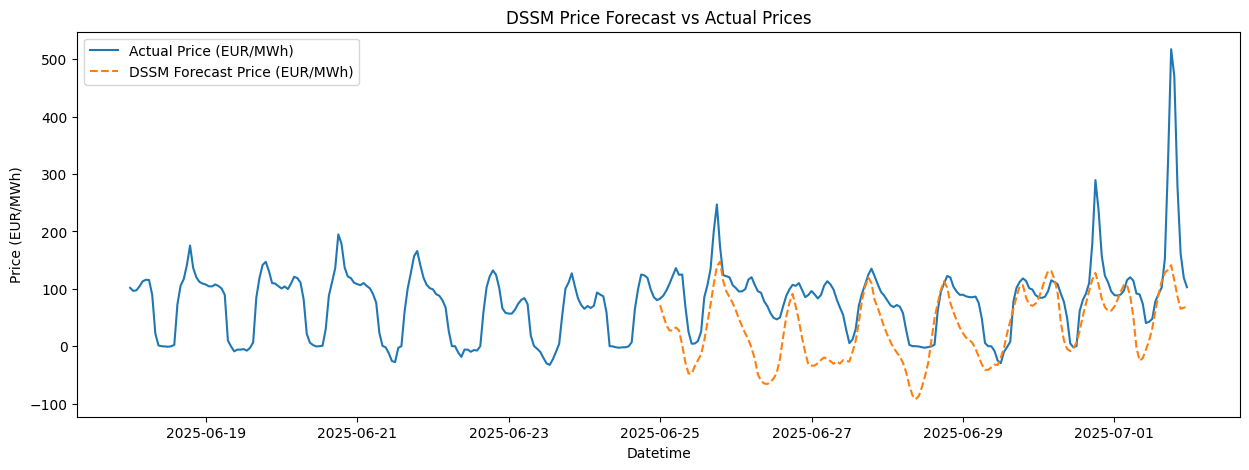

In [31]:
import sys
import pandas as pd
sys.path.append("../src")

from data.fetch_prices import get_energy_prices

df_prices = get_energy_prices("202506180000", "202507020000")

# plot vs predictions
plt.figure(figsize=(15, 5))
plt.plot(df_prices["datetime"], df_prices["price_EUR_MWh"], label="Actual Price (EUR/MWh)")
plt.plot(forecast_datetimes, forecast_unscaled, label="DSSM Forecast Price (EUR/MWh)", linestyle="--")
plt.title("DSSM Price Forecast vs Actual Prices")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()
